In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.backend_bases import MouseButton, KeyEvent
import jax
import jax.numpy as jnp
import gmsh

# the jax for DIC module
import D2IC.ker_function as kf


jax.config.update("jax_enable_x64", True)
jax.devices('cuda')
jax.config.update("jax_default_device", jax.devices("gpu")[0])

## Laod 2 images

In [3]:
# ...existing code...
# Simple widget: un upload pour image réf (im1) et un upload pour image déf (im2), aperçu côte-à-côte
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def _to_gray_if_needed(arr):
    if arr is None:
        return None
    arr = np.asarray(arr)
    if arr.ndim == 3 and arr.shape[2] >= 3:
        return arr[..., :3].mean(axis=-1)
    return arr

def _set_image_from_array(arr, target='im1', path=None):
    arr = np.asarray(arr)
    arr = _to_gray_if_needed(arr)
    globals()[target] = jnp.array(arr, dtype=jnp.float32)
    globals()[f'{target}_path'] = path
    _preview_images()

def _load_from_bytes(b, name=None, target='im1'):
    img = np.array(Image.open(io.BytesIO(b)))
    _set_image_from_array(img, target=target, path=name)

def _preview_images():
    with out:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        imgs = [globals().get('im1', None), globals().get('im2', None)]
        paths = [globals().get('im1_path', None), globals().get('im2_path', None)]
        titles = ['Image réf (im1)', 'Image déf (im2)']
        for ax, img, p, t in zip(axes, imgs, paths, titles):
            if img is None:
                ax.text(0.5, 0.5, f'Aucune {t}', ha='center', va='center', fontsize=12)
                ax.set_axis_off()
            else:
                ax.imshow(np.asarray(img), cmap='gray', origin='lower')
                ax.set_title(f"{t}: {os.path.basename(p) if p else 'uploaded'}")
                ax.set_axis_off()
        plt.tight_layout()
        plt.show()

out = widgets.Output()

# Two simple upload widgets (each provides a single button)
uploader_ref = widgets.FileUpload(accept='image/*', multiple=False, description='Upload réf (im1)')
uploader_def = widgets.FileUpload(accept='image/*', multiple=False, description='Upload déf (im2)')

def _handle_upload(uploader, target):
    val = uploader.value
    if not val:
        return
    # different frontends may provide dict or tuple/list
    if isinstance(val, dict):
        fileinfo = list(val.values())[0]
    else:
        fileinfo = list(val)[0]
        if isinstance(fileinfo, str):
            fileinfo = val[fileinfo]
    content = fileinfo.get('content') or fileinfo.get('data')
    name = fileinfo.get('name') or getattr(fileinfo, 'name', None)
    if content is not None:
        _load_from_bytes(content, name=name, target=target)

def _on_ref_change(change):
    _handle_upload(uploader_ref, 'im1')

def _on_def_change(change):
    _handle_upload(uploader_def, 'im2')

uploader_ref.observe(_on_ref_change, names='value')
uploader_def.observe(_on_def_change, names='value')

# Layout: upload buttons on a single row, preview below
controls = widgets.HBox([
    widgets.VBox([widgets.HTML("<b>Référence (im1)</b>"), uploader_ref]),
    widgets.VBox([widgets.HTML("<b>Déformée (im2)</b>"), uploader_def])
])

display(widgets.VBox([controls, out]))

# Initial preview
_preview_images()
# ...existing code...

In [4]:
# Meshed-ROI defined with a mask
import io
from pathlib import Path

import meshio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

from D2IC import generate_roi_mesh

Path('SandBox').mkdir(exist_ok=True)
_mask_path = None
_mask_name = None

mask_uploader = widgets.FileUpload(accept='image/*', multiple=False, description='Upload masque')
element_size = widgets.FloatSlider(value=20.0, min=2.0, max=150.0, step=1.0, description='h (px)')
approx_slider = widgets.FloatLogSlider(value=1e-2, base=10, min=-4, max=-1, step=0.1, description='tol approx')
generate_button = widgets.Button(description='Créer le maillage', button_style='success', icon='check')
status_out = widgets.Output()
mask_preview = widgets.Output()
mesh_preview = widgets.Output()


def _extract_payload(val):
    if not val:
        return None
    if isinstance(val, dict):
        return list(val.values())[0]
    if isinstance(val, (list, tuple)):
        entry = val[0]
        if isinstance(entry, str):
            entry = val[entry]
        return entry
    entry = list(val)[0]
    if isinstance(entry, str):
        entry = val[entry]
    return entry


def _handle_mask_upload(change):
    global _mask_path, _mask_name
    payload = _extract_payload(mask_uploader.value)
    mask_preview.clear_output()
    status_out.clear_output()
    if not payload:
        _mask_path = None
        _mask_name = None
        return
    data = payload.get('content') or payload.get('data')
    name = payload.get('name') or 'mask.png'
    if data is None:
        return
    suffix = Path(name).suffix or '.png'
    _mask_path = Path('SandBox') / f'roi_mask_uploaded{suffix}'
    _mask_path.write_bytes(data)
    _mask_name = name
    mask_img = np.array(Image.open(io.BytesIO(data)))
    with mask_preview:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        plt.imshow(mask_img, cmap='gray', origin='lower')
        plt.title(f"Masque: {name}")
        plt.axis('off')
        plt.show()


mask_uploader.observe(_handle_mask_upload, names='value')


def _plot_mesh_on_reference(mesh_path: Path):
    with mesh_preview:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5, 5))
        ref_img = globals().get('im1')
        if ref_img is not None:
            ax.imshow(np.asarray(ref_img), cmap='gray', origin='lower')
            ax.set_xlim(0, ref_img.shape[1])
            ax.set_ylim(0, ref_img.shape[0])
        else:
            ax.set_facecolor('0.95')
            ax.text(0.5, 0.5, "Chargez d'abord l'image de référence (im1)", ha='center', va='center')
        mesh = meshio.read(str(mesh_path))
        surface_cells = None
        for block in mesh.cells:
            if block.type in ('quad', 'triangle') and block.data.size:
                surface_cells = block.data
                break
        if surface_cells is None:
            ax.text(0.5, 0.5, 'Maillage sans éléments surfaciques', ha='center', va='center')
        else:
            nodes = mesh.points[:, :2]
            polys = nodes[surface_cells]
            collection = PolyCollection(polys, facecolors='none', edgecolors='tab:red', linewidths=1.2)
            ax.add_collection(collection)
            ax.set_aspect('equal')
        ax.set_title('Maillage superposé à la référence')
        plt.show()


def _generate_mesh(_):
    status_out.clear_output()
    mesh_preview.clear_output()
    if _mask_path is None:
        with status_out:
            print("Merci de charger un masque binaire avant de lancer la génération du maillage.")
        return
    msh_path = Path('roi_mesh.msh')
    try:
        generate_roi_mesh(
            _mask_path,
            element_size=float(element_size.value),
            msh_path=str(msh_path),
            approx_tolerance=float(approx_slider.value),
        )
    except Exception as exc:
        with status_out:
            print(f"Erreur pendant la génération du maillage: {exc}")
        return
    with status_out:
        print(
            f"Maillage enregistré: {msh_path.resolve()} (h={element_size.value:.1f}, tol={approx_slider.value:.1e})"
        )
    _plot_mesh_on_reference(msh_path)


generate_button.on_click(_generate_mesh)

display(widgets.VBox([
    widgets.HTML("<b>1. Chargez un masque binaire (ROI blanche / fond noir)</b>"),
    mask_uploader,
    mask_preview,
    widgets.HTML("<b>2. Paramétrez puis générez le maillage Gmsh</b>"),
    widgets.HBox([element_size, approx_slider]),
    generate_button,
    status_out,
    mesh_preview,
]))



## DIC

In [5]:
from pathlib import Path

mesh_file = Path('roi_mesh.msh')
if mesh_file.exists():
    print(f"Maillage disponible: {mesh_file.resolve()}")
else:
    print("Aucun maillage 'roi_mesh.msh' détecté. Générez-le à partir du masque avant de poursuivre.")
#from D2IC.dic import Dic
from D2IC.dicPixWhise import Dic

mesh_file = "roi_mesh.msh"
dic_study = Dic(mesh_file)

# precompute pixel data for im1 
img = np.asarray(im1)
dic_study.precompute_pixel_data(im1)


Maillage disponible: /workspaces/08_dic/D2IC/doc/roi_mesh.msh



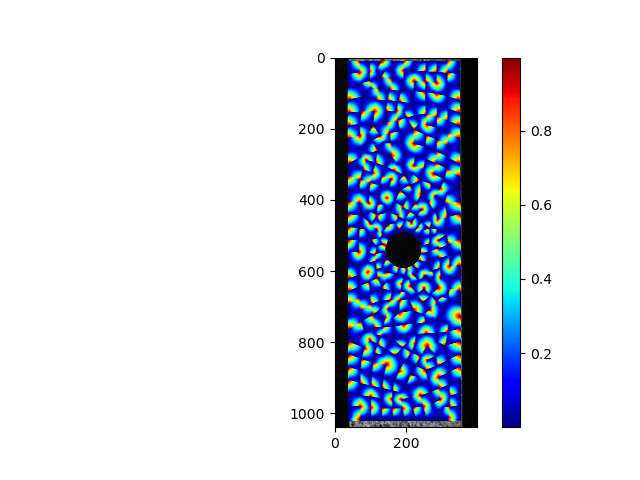

In [27]:
#plot shape function
N = dic_study.pixel_shapeN[:,2]
plt.figure()
plt.imshow(img, cmap='gray')
plt.scatter(dic_study.pixel_coords_ref[:,0], dic_study.pixel_coords_ref[:,1], s= 1, c = N, cmap='jet')
plt.colorbar()
plt.show()

In [7]:
disp_guess, extras = dic_study.compute_feature_disp_guess_big_motion(
                        im1, im2,
                        n_patches=64,
                        refine=True,
                        ransac_model='affine',
                        patch_win=13,
                        patch_search=101,
                        search_dilation=1.0,
                        )
disp_guess.mean()

Array(-19.06171796, dtype=float64)

In [9]:
extras

{'model': <AffineTransform(matrix=
     [[ 1.02418283e+00, -2.57895781e-03, -5.43377433e+01],
      [ 1.55547794e-03,  9.89183218e-01,  2.35436100e+01],
      [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x7f8cc9f50950>,
 'pts_ref': array([[ 936.,  236.],
        [ 843.,  295.],
        [ 971.,   83.],
        [ 856.,  162.],
        [1025.,  154.],
        [ 562.,  589.],
        [ 815.,   97.],
        [ 559.,  410.],
        [ 374.,  516.],
        [ 770.,  109.],
        [ 628.,  763.],
        [1390.,  818.],
        [ 622.,  575.],
        [ 609.,  509.],
        [ 817.,  214.],
        [ 508.,  689.],
        [ 471.,  517.],
        [ 596.,  800.],
        [ 807.,  149.],
        [ 604.,  670.],
        [ 537.,  572.],
        [ 503.,  480.],
        [ 492.,  427.],
        [ 693.,  188.],
        [ 794.,  188.],
        [ 535.,  545.],
        [ 497.,  785.],
        [ 593.,  756.],
        [1143.,  225.],
        [ 560.,  805.]]),
 'pts_def': array([[ 903.,  260.],

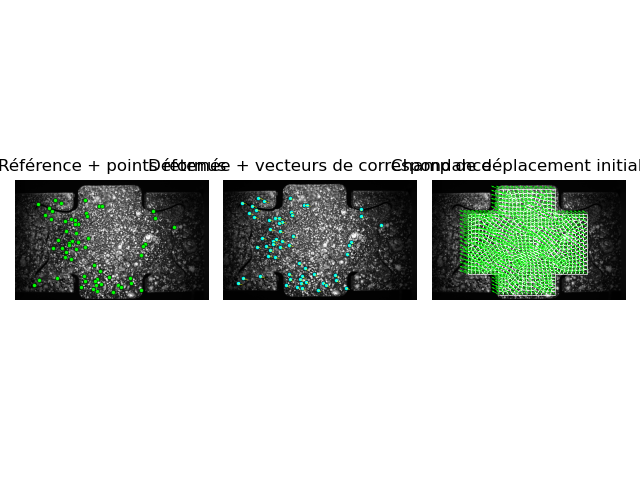

In [10]:
from matplotlib.collections import LineCollection
pts_ref = extras["raw_pts_ref"]
pts_def = extras["raw_pts_def"]

nodes = np.asarray(dic_study.node_coordinates_binned[:, :2])
elements = np.asarray(dic_study.element_conectivity, dtype=int)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)

ax = axes[0]
ax.imshow(im1, cmap="gray")
ax.scatter(pts_ref[:, 0], pts_ref[:, 1], s=8, c="lime", edgecolor="k", linewidth=0.3)
ax.set_title("Référence + points retenus")
ax.set_axis_off()

ax = axes[1]
ax.imshow(im2, cmap="gray")
ax.scatter(pts_def[:, 0], pts_def[:, 1], s=8, c="cyan", edgecolor="k", linewidth=0.3)
ax.quiver(
    pts_ref[:, 0],
    pts_ref[:, 1],
    pts_def[:, 0] - pts_ref[:, 0],
    pts_def[:, 1] - pts_ref[:, 1],
    angles="xy",
    scale_units="xy",
    scale=1.0,
    color="yellow",
    width=0.002,
)
ax.set_title("Déformée + vecteurs de correspondance")
ax.set_axis_off()

ax = axes[2]
ax.imshow(im1, cmap="gray", alpha=1.)
polys = nodes[elements]
segments = []
for poly in polys:
    loop = np.vstack([poly, poly[0]])
    segments.extend(np.stack([loop[:-1], loop[1:]], axis=1))
line_collection = LineCollection(segments, colors="white", linewidths=0.5)
ax.add_collection(line_collection)
ax.quiver(
    nodes[:, 0],
    nodes[:, 1],
    disp_guess[:, 0],
    disp_guess[:, 1],
    color="lime",
    angles="xy",
    scale_units="xy",
    scale=1.0,
    width=0.003,
    zorder=5,
)
ax.set_title("Champ de déplacement initialisé")
ax.set_axis_off()

for ax in axes:
    ax.set_aspect("equal")
    ax.invert_yaxis()

fig.tight_layout()
plt.savefig("figure.png", dpi=150)
plt.show()

## Image binning


In [11]:
displacement = disp_guess 
binning = 1

In [12]:
m, n = im1.shape
m_bins = m//binning
n_bins = n//binning
im1b = im1.reshape(m_bins, m // m_bins, n_bins, n // n_bins)
im1b = im1b.mean(axis=(1, 3))
im2b = im2.reshape(m_bins, m // m_bins, n_bins, n // n_bins)
im2b = im2b.mean(axis=(1, 3))
dic_study.set_binning(binning)

In [ ]:
displacement, hist = dic_study.run_dic_lm(
                   im1b,
                   im2b,
                   disp_guess=displacement,
                   max_iter= 30,
                   lm_damping=1e-2,
                   reg_type="spring",
                   alpha_reg=0.05,
                   cg_maxiter=50,
                   cg_tol=1e-4)

In [13]:
# DIC globale + ressorts (pondérée par géométrie)
displacement, hist = dic_study.run_dic(
    im1b, im2b,
    disp_guess=displacement,
    max_iter=500,
    tol=1e-3,
    reg_type="spring",#"spring"
    alpha_reg=100,
)

[CG] iter   0  J=6.4927e+03  ||g||=6.790e+01
        alpha=1.250e-01, J_new=6.2302e+03
[CG] iter   1  J=6.2302e+03  ||g||=6.452e+01
        alpha=1.250e-01, J_new=6.0083e+03
[CG] iter   2  J=6.0083e+03  ||g||=5.842e+01
        alpha=1.250e-01, J_new=5.8334e+03
[CG] iter   3  J=5.8334e+03  ||g||=5.868e+01
        alpha=1.250e-01, J_new=5.6586e+03
[CG] iter   4  J=5.6586e+03  ||g||=5.977e+01
        alpha=1.250e-01, J_new=5.4670e+03
[CG] iter   5  J=5.4670e+03  ||g||=5.698e+01
        alpha=1.250e-01, J_new=5.3103e+03
[CG] iter   6  J=5.3103e+03  ||g||=5.959e+01
        alpha=1.250e-01, J_new=5.1444e+03
[CG] iter   7  J=5.1444e+03  ||g||=5.891e+01
        alpha=1.250e-01, J_new=4.9890e+03
[CG] iter   8  J=4.9890e+03  ||g||=5.799e+01
        alpha=1.250e-01, J_new=4.8235e+03
[CG] iter   9  J=4.8235e+03  ||g||=5.619e+01
        alpha=1.250e-01, J_new=4.7177e+03
[CG] iter  10  J=4.7177e+03  ||g||=5.804e+01
        alpha=1.250e-01, J_new=4.6450e+03
[CG] iter  11  J=4.6450e+03  ||g||=6.139e+0

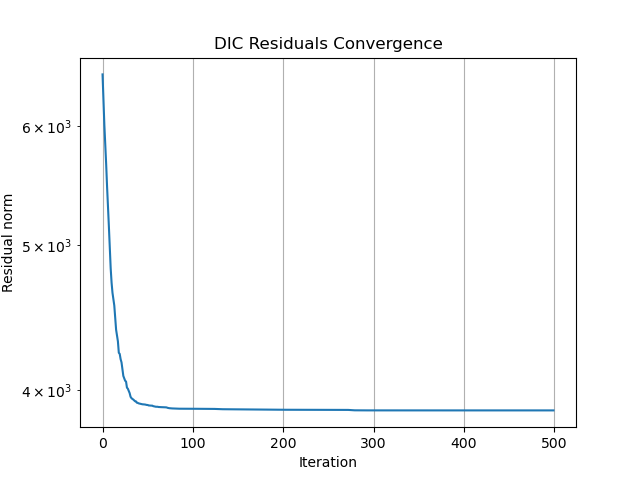

In [14]:
hist = jnp.asarray(hist)
plt.figure()
plt.plot(hist[:,0], label='Residuals')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual norm')
plt.title('DIC Residuals Convergence')
plt.grid(True)
plt.show()

In [28]:
# raffinement Laplacien pur
displacement = dic_study.run_dic_nodal(
    im1b, im2b,
    disp_init=displacement,
    n_sweeps=7,
    lam=0.1,
    reg_type="spring_jacobi", #"spring" "laplace" spring_jacobi
    alpha_reg=1000.,
    max_step=0.2,
)

[Nodal-spring_jacobi] sweep 1/7, J=3.9953e+03
[Nodal-spring_jacobi] sweep 2/7, J=3.9766e+03
[Nodal-spring_jacobi] sweep 3/7, J=3.9599e+03
[Nodal-spring_jacobi] sweep 4/7, J=3.9450e+03
[Nodal-spring_jacobi] sweep 5/7, J=3.9316e+03
[Nodal-spring_jacobi] sweep 6/7, J=3.9184e+03
[Nodal-spring_jacobi] sweep 7/7, J=3.9037e+03


## Post-processing

In [29]:
F_all, E_all = dic_study.compute_green_lagrange_strain_nodes(displacement, k_ring=2, gauge_length=100.)

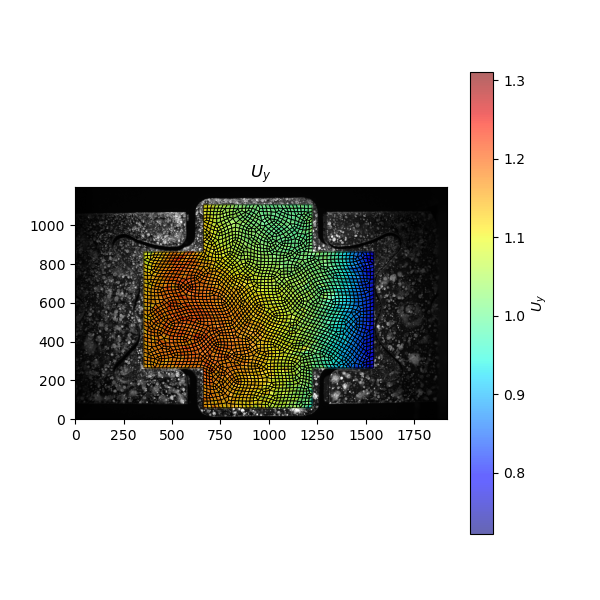

In [14]:
from D2IC.dic_plotter import DICPlotter
plotter = DICPlotter(
    background_image=im2,
    displacement=displacement,
    strain_fields=(F_all, E_all),
    dic_object=dic_study,
)
fig, ax = plotter.plot_displacement_component(component='Uy')



In [30]:
plotter.show_interactive()
